## ECGR Homework 1

Patrick Flynn
801055057

In [ ]:
pip install d2l==1.0.0b0

# Part 1

**Problem 1:**

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

60000
10000
torch.Size([1, 32, 32])



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 1, 32, 32]) torch.float32 torch.Size([64]) torch.int64



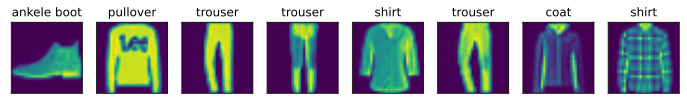

In [ ]:
%matplotlib inline
import torch
import time
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import torch.nn.functional as F

d2l.use_svg_display()

class FashionMNIST(d2l.DataModule):
    def __init__(self, batch_size=64, resize=(28,28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
        self.train = torchvision.datasets.FashionMNIST(
            root=self.root, train=True, transform=trans, download=True
        )
        self.val = torchvision.datasets.FashionMNIST(
            root=self.root, train=False, transform=trans, download=True
        )

@d2l.add_to_class(FashionMNIST)
def text_labels(self, indicies):
    labels = [ "t-shirt", "trouser", "pullover", "dress", "coat",
              "sandal", "shirt", "sneaker", "bag", "ankele boot" ]
    return [labels[int(i)] for i in indicies]

@d2l.add_to_class(FashionMNIST)
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)
    
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    raise NotImplementedError

@d2l.add_to_class(FashionMNIST)
def visualize(self, batch, nrows=1, ncols=8, labels=[]):
  X, Y = batch
  if not labels:
      labels = self.text_labels(Y)
  d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

data = FashionMNIST(resize=(32,32))
print(len(data.train))
print(len(data.val))
print(data.train[0][0].shape)

print("")

X, Y = next(iter(data.train_dataloader()))
print(X.shape, X.dtype, Y.shape, Y.dtype)

print("")

batch = next(iter(data.val_dataloader()))
data.visualize(batch)

Next part

In [ ]:
class Classifier(d2l.Module):
    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot("loss", self.loss(Y_hat, batch[-1]), train=False)
        self.plot("acc", self.accuracy(Y_hat, batch[-1]), train=False)

@d2l.add_to_class(d2l.Module)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), lr=self.lr)
  
@d2l.add_to_class(Classifier)
def accuracy(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    preds = Y_hat.argmax(axis=1).type(Y.dtype)
    compare = (preds == Y.reshape(-1)).type(torch.float32)
    return compare.mean() if averaged else compare

@d2l.add_to_class(Classifier)
def loss(self, Y_hat, Y, averaged=True):
    Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
    Y = Y.reshape((-1,))
    return F.cross_entropy(Y_hat, Y, reduction="mean" if averaged else "none")

class SoftmaxRegression(d2l.Classifier):
    def __init__(self, num_outputs, hl1, hl2, hl3, lr):
        super().__init__()
        self.save_hyperparameters()
        #self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_outputs))
        #self.net = nn.Sequential(nn.Flatten(), nn.Flatten(), nn.Flatten(), nn.LazyLinear(num_outputs))
        self.net = nn.Sequential(nn.Flatten(),
                          nn.LazyLinear(hl1), nn.ReLU(),
                          nn.LazyLinear(hl2), nn.ReLU(),
                          nn.LazyLinear(hl3), nn.ReLU(),
                          nn.LazyLinear(num_outputs)
                    )
    
    def forward(self, X):
        return self.net(X)

### Standard Training

1.a. train the model from scratch (with randomized parameters) and plot the results (training loss and accuracy, validation accuracy) after 20 epochs. Does your network need more epochs for full training? Do you observe overfitting? Make sure to save the trained parameters and model. 

Training time from scratch (20 epochs): 240.24491095542908


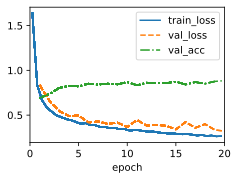

In [ ]:
import time
time1 = time.time()

data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, hl1=512, hl2=256, hl3=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=20)
trainer.fit(model, data)

time2 = time.time() - time1
print("Training time from scratch (20 epochs): " + str(time2))

Print our metrics and save them for future loading:

In [ ]:
print("Our Model: \n\n", model, '\n')
print("The State Dict Keys: \n\n", model.state_dict().keys())

Our Model: 

 SoftmaxRegression(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=10, bias=True)
  )
) 

The State Dict Keys: 

 odict_keys(['net.1.weight', 'net.1.bias', 'net.3.weight', 'net.3.bias', 'net.5.weight', 'net.5.bias', 'net.7.weight', 'net.7.bias'])


In [ ]:
torch.save(model.state_dict(), 'MultiLayer_Perceptron_Model.params')

Training with more epochs for comparison:

Training time from scratch: 626.2935252189636


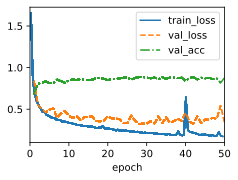

In [ ]:
import time
time1 = time.time()

data = d2l.FashionMNIST(batch_size=256)
model = SoftmaxRegression(num_outputs=10, hl1=512, hl2=256, hl3=256, lr=0.1)
trainer = d2l.Trainer(max_epochs=50)
trainer.fit(model, data)

time2 = time.time() - time1
print("Training time from scratch: " + str(time2))

Reload and run:

In [ ]:
# Recovering the Stored Model (Parameters)
saved_model = SoftmaxRegression(num_outputs = 10, hl1 = 512, hl2 = 256, hl3 = 256, lr = 0.1)
saved_model.load_state_dict(torch.load('MultiLayer_Perceptron_Model.params'))
saved_model.eval()

SoftmaxRegression(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=512, bias=True)
    (2): ReLU()
    (3): LazyLinear(in_features=0, out_features=256, bias=True)
    (4): ReLU()
    (5): LazyLinear(in_features=0, out_features=256, bias=True)
    (6): ReLU()
    (7): LazyLinear(in_features=0, out_features=10, bias=True)
  )
)

Training time from loading: 239.87332844734192


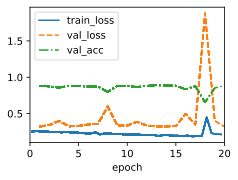

In [ ]:
import time
time1 = time.time()

trainer = d2l.Trainer(max_epochs = 20)
trainer.fit(saved_model, data)

time2 = time.time() - time1
print("Training time from loading: " + str(time2))

### Weight Decay

1.b Report section a; this time add weight penalties (weight decays). Report and plot your training results. how do the training results change compared to the baseline? (15pts)

In [ ]:
class WeightDecay(Classifier):
    def __init__(self, num_inputs, hl1, hl2, hl3, wd, lr, sigma=0.01):
        super().__init__(lr)
        self.save_hyperparameters()
        self.wd = wd
        self.weights = torch.normal(0, sigma, (hl1, 1), requires_grad=True)
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(hl1), nn.ReLU(),
                                 nn.LazyLinear(hl2), nn.ReLU(),
                                 nn.LazyLinear(hl3), nn.ReLU(),
                                 nn.LazyLinear(num_inputs))

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y = Y.reshape((-1))
        return (super().loss(Y_hat, Y) + self.wd * l2_penalty(self.weights))
    
    def forward(self, X):
        return self.net(X)

def l2_penalty(w):
    return (w ** 2).sum() / 2

data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=20)

def train_scratch():
    start_time = time.time()
    model.board.yscale='log'
    trainer.fit(model, data)
    end_time = time.time() - start_time
    print("Total time training: " + str(end_time))
    print("")


Total time training: 238.43928837776184



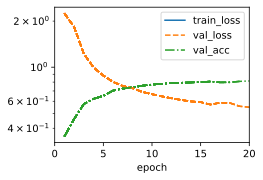

In [ ]:
model = WeightDecay(num_inputs=10, hl1=512, hl2=256, hl3=256, wd=1, lr=0.01)
train_scratch()
torch.save(model.state_dict(), 'MLP_weightDecay.params')

### With Dropout

1.c Report section a; this time add dropout (dropout = 0.3). Report and plot your training results. how do the training results change compared to the baseline? How the training results change compared to the weight penalties. 

Total time training: 240.68726706504822



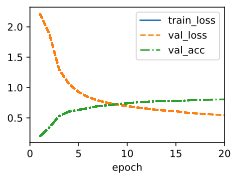

In [ ]:
class DropOut(Classifier):
    def __init__(self, num_inputs, hl1, hl2, hl3, dpo1, dpo2, dpo3, lr, sigma=0.01):
        super().__init__(lr)
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(),
                                 nn.LazyLinear(hl1), nn.ReLU(), nn.Dropout(dpo1),
                                 nn.LazyLinear(hl2), nn.ReLU(), nn.Dropout(dpo2),
                                 nn.LazyLinear(hl3), nn.ReLU(), nn.Dropout(dpo3),
                                 nn.LazyLinear(num_inputs))

    def loss(self, Y_hat, Y, averaged=True):
        Y_hat = Y_hat.reshape((-1, Y_hat.shape[-1]))
        Y = Y.reshape((-1))
        return F.cross_entropy(Y_hat, Y, reduction = "mean" if averaged else "none")
    
    def forward(self, X):
        return self.net(X)

def l2_penalty(w):
    return (w ** 2).sum() / 2

data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=20)
model = DropOut(num_inputs=10, hl1=512, hl2=256, hl3=256, dpo1=0.3, dpo2=0.3, dpo3=0.3, lr=0.01)
start_time = time.time()
trainer.fit(model, data)
end_time = time.time() - start_time
print("Total time training: " + str(end_time))
print("")


# Part 2

Kaggle Dataset

Part one: setup and load everything

In [13]:
%matplotlib inline
import pandas as pd
import torch
import time
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import torch.nn.functional as F

# Create the class for our data
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))
    
    def preprocess(self):
        # Remove the ID and label columns
        features = pd.concat((
            self.raw_train.drop(columns=["Id", "SalePrice"]),
            self.raw_val.drop(columns=["Id"])
        ))

        # Standardize the numerical columns
        num_features = features.dtypes[features.dtypes != "object"].index
        features[num_features] = features[num_features].apply(lambda x: (x-x.mean()) / x.std())

        # Replace any NANs with 0
        features[num_features] = features[num_features].fillna(0)

        # Replace with discrete features by one-hot encoding
        features = pd.get_dummies(features, dummy_na=True)

        # Finally, save all features
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train["SalePrice"] = self.raw_train["SalePrice"]
        self.val = features[self.raw_train.shape[0]:].copy()

# Load the data set
data = KaggleHouse(batch_size = 64)
print(data.raw_train.shape)
print(data.raw_val.shape)

print("-------")

data.preprocess()
print(data.train.shape)
print(data.val.shape)

(1460, 81)
(1459, 80)
-------
(1460, 332)
(1459, 331)


In [14]:
data.raw_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [15]:
# Visualize our preprocessed data
data.train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_WD,SaleType_nan,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan,SalePrice
0,0.067320,-0.184443,-0.217841,0.646073,-0.507197,1.046078,0.896679,0.523038,0.580708,-0.293030,...,1,0,0,0,0,0,1,0,0,208500
1,-0.873466,0.458096,-0.072032,-0.063174,2.187904,0.154737,-0.395536,-0.569893,1.177709,-0.293030,...,1,0,0,0,0,0,1,0,0,181500
2,0.067320,-0.055935,0.137173,0.646073,-0.507197,0.980053,0.848819,0.333448,0.097840,-0.293030,...,1,0,0,0,0,0,1,0,0,223500
3,0.302516,-0.398622,-0.078371,0.646073,-0.507197,-1.859033,-0.682695,-0.569893,-0.494771,-0.293030,...,1,0,1,0,0,0,0,0,0,140000
4,0.067320,0.629439,0.518814,1.355319,-0.507197,0.947040,0.753100,1.381770,0.468770,-0.293030,...,1,0,0,0,0,0,1,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.067320,-0.312950,-0.285421,-0.063174,-0.507197,0.914028,0.753100,-0.569893,-0.968860,-0.293030,...,1,0,0,0,0,0,1,0,0,175000
1456,-0.873466,0.672275,0.381246,-0.063174,0.391170,0.220763,0.178782,0.093673,0.765076,0.670295,...,1,0,0,0,0,0,1,0,0,210000
1457,0.302516,-0.141607,-0.142781,0.646073,3.086271,-1.000704,1.040259,-0.569893,-0.365275,-0.293030,...,1,0,0,0,0,0,1,0,0,266500
1458,-0.873466,-0.055935,-0.057197,-0.772420,0.391170,-0.703591,0.561660,-0.569893,-0.861312,5.788329,...,1,0,0,0,0,0,1,0,0,142125


In [16]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = "SalePrice"
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values, dtype=torch.float32)
    tensors = (get_tensor(data.drop(columns=[label])),
               torch.log(get_tensor(data[label])).reshape((-1, 1)))
    return self.get_tensorloader(tensors, train)

Our training loop

In [17]:
%matplotlib inline
import torch
from d2l import torch as d2l

class LinearRegression(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        #self.net = nn.LazyLinear()
        #self.net = nn.ReLU()
        #self.net = nn.LazyLinear()
        self.net = nn.Sequential(
                                 nn.LazyLinear(256), nn.ReLU(), #nn.Dropout(),
                                 nn.LazyLinear(256), nn.ReLU(), #nn.Dropout(),
                                 nn.LazyLinear(256), nn.ReLU(), #nn.Dropout(),
                                 #nn.LazyLinear(512)
                                 )
        #self.net.weight.data.normal_(0, 0.01)
        #self.net.bias.data.fill_(0)

@d2l.add_to_class(LinearRegression)
def forward(self, X):
    """The linear regression model."""
    return self.net(X)

@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

Training:

In [18]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0:  # To be discussed later
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

In [19]:
print(data.train.shape)
print(data.val.shape)

(1460, 332)
(1459, 331)


KFold

In [20]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models


2.a What happens if we need to standardize the continuous numerical features like what we have done in this section?

average validation log mse = 37.570368423461915


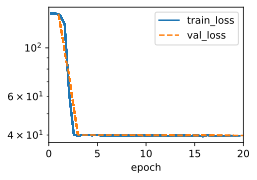

In [21]:
trainer = d2l.Trainer(max_epochs=20)
models = k_fold(trainer, data, k=5, lr=0.01)

2.b Improve the score by improving the model complexity. Please plot the training results and compare them against the baseline model we did in the lectures. How about the model complexity comparison and training time? (15pt)

In [22]:
%matplotlib inline
import torch
from d2l import torch as d2l

class LinearRegression(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
                                 nn.LazyLinear(512), nn.ReLU(), #nn.Dropout(),
                                 nn.LazyLinear(512), nn.ReLU(), #nn.Dropout(),
                                 nn.LazyLinear(512), nn.ReLU(), #nn.Dropout(),
                                 nn.LazyLinear(512), nn.ReLU(), #nn.Dropout(),
                                 nn.LazyLinear(512), nn.ReLU(), #nn.Dropout(),
                                 nn.LazyLinear(512), nn.ReLU(), #nn.Dropout(),
                                 )
        #self.net.weight.data.normal_(0, 0.01)
        #self.net.bias.data.fill_(0)

@d2l.add_to_class(LinearRegression)
def forward(self, X):
    """The linear regression model."""
    return self.net(X)

@d2l.add_to_class(LinearRegression)
def loss(self, y_hat, y):
    fn = nn.MSELoss()
    return fn(y_hat, y)

@d2l.add_to_class(LinearRegression)
def configure_optimizers(self):
    return torch.optim.SGD(self.parameters(), self.lr)

average validation log mse = 51.075670928955084


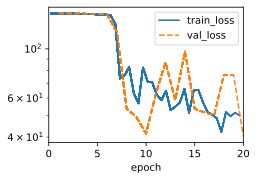

In [23]:
trainer = d2l.Trainer(max_epochs=20)
models = k_fold(trainer, data, k=5, lr=0.01)

Make a submission of predictions:

In [24]:
preds = [model(torch.tensor(data.val.values, dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)